# Stack Overflow Tag Prediction 2: Topic Modeling

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers. The goal of this project is to predict as many tags as possible with high precision and recall. Incorrect tags could impact user experience on StackOverflow. 

To automatically assign tags we use in a first step an unsupervised approach: the text analysis technique called topic modeling. The ultimate goal of topic modeling is to find various topics that are present in your corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics.

## Import libraries and load dataset

In [0]:
import pandas as pd
import numpy as np
import nltk, re, pprint
from nltk import word_tokenize, pos_tag

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from gensim import matutils, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import preprocess_documents
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models.word2vec import Word2Vec
import time

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from matplotlib.legend_handler import HandlerLine2D

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn import model_selection

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import jaccard_score

from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint as sp_randint

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
import re


In [2]:
df_base = pd.read_csv('stackoverflow_processed_sample.csv', encoding='utf-8')
df_base.head()

,Lemma,lemmalist,tags,taglist
0,"['processing', 'sort', 'array', 'faster', 'pro...",processing sort array faster processing unsort...,"['java', 'c++', 'performance', 'optimization',...",java c++ performance optimization branch-predi...
1,"['undo', 'recent', 'local', 'commits', 'git', ...",undo recent local commits git accidentally com...,"['git', 'version-control', 'git-commit', 'undo...",git version-control git-commit undo pre-commit
2,"['delete', 'git', 'branch', 'locally', 'remote...",delete git branch locally remotely want delete...,"['git', 'version-control', 'git-branch', 'git-...",git version-control git-branch git-push git-re...
3,"['difference', 'git', 'pull', 'git', 'fetch', ...",difference git pull git fetch difference git p...,"['git', 'version-control', 'git-pull', 'git-fe...",git version-control git-pull git-fetch
4,"['correct', 'json', 'content', 'type', 'mess',...",correct json content type mess json time push ...,"['json', 'http-headers', 'content-type']",json http-headers content-type


In [0]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

## Encoded target matrix

In [0]:
one_hot = MultiLabelBinarizer() # encoder for the  tags 
y = df_base['taglist']
y_onehot = one_hot.fit_transform(y.str.split(' ')) 
y_bin = pd.DataFrame(y_onehot, columns=one_hot.classes_ ) # transform it to Pandas object

In [5]:
print(y_bin.shape) # verify the result
y_bin[:2] # still lots of non-relevant columns


(37175, 8578)


,.a,.bash-profile,.d.ts,.htaccess,.net,.net-2.0,.net-3.0,.net-3.5,.net-4.0,.net-4.5,.net-4.5.2,.net-assembly,.net-attributes,.net-client-profile,.net-core,.net-core-3.0,.net-framework-version,.net-standard,.net-standard-2.0,.when,16-bit,2048,2d,32-bit,32bit-64bit,3d,3g,3nf,64-bit,7zip,a-records,a-star,aapt,aar,abbreviation,abc,abi,abort,absolute,absolute-path,...,yeoman,yesod,yield,yield-keyword,yield-return,youtube,youtube-api,youtube-data-api,youtube-iframe-api,youtube-javascript-api,yui,yum,z-index,z-order,zalgo,zebra-puzzle,zen-of-python,zend-framework2,zend-studio,zepto,zero,zero-extension,zero-pad,zero-padding,zerofill,zeromq,zip,zipalign,ziparchive,zipcode,zipfile,zipper,zlib,zombie-process,zoo,zoom,zsh,zsh-completion,zurb-foundation,zxing
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Tags to be selected**

In [0]:
Number_tags = 150 # number to choose in order of popularity

In [0]:
df_tags = pd.read_csv('stackoverflow_processed_tags.csv', encoding='utf-8') # load the taglist in order to perform a tags selection
df_tags = df_tags.dropna()
tags = df_tags.tag #tags ordered by popularity

popular_tags = tags[:Number_tags].tolist() # get the list of n most popular tags


select only popular tags from tags encoded matrix using filter function

In [8]:
y_bin = y_bin.filter(items=popular_tags)

y_bin[:2]

,javascript,python,java,c#,android,html,git,css,jquery,c++,ios,.net,php,string,sql,mysql,bash,node.js,arrays,c,linux,objective-c,sql-server,ruby,swift,json,shell,ruby-on-rails,iphone,angularjs,list,xcode,windows,regex,r,visual-studio,performance,asp.net,database,macos,...,enums,ubuntu,batch-file,design-patterns,random,ssh,loops,gcc,pip,ecmascript-6,inheritance,powershell,coding-style,file-io,path,terminal,visual-studio-2010,laravel,oracle,directory,optimization,android-fragments,reflection,parsing,operators,lambda,branch,csv,ruby-on-rails-3,math,terminology,asynchronous,time,validation,scripting,uitableview,visual-studio-code,hibernate,unicode,floating-point
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
print(y_bin.shape) # verify shape

(37175, 150)


## 1. Document-term matrix


To use a topic modeling technique, we calculate have to calculate (1) a document-term matrix and (2) choose the number of topics for the algorithm to pick up.
Documemt-term matrix is calculated using either using the "Bag of Words" or "TF-IDF" approach.
The number of topics is chosen beforehands

**Features to be modeled**

In [0]:
num_features = 220

### 1.1 Bag of Words approach

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors, i.e build a document-term matrix.
One common approach is called a Bag of Words. The Bag of Words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. 

In [0]:
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool
c_vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,  min_df=5, max_df = 0.8, max_features = num_features, ngram_range=(1, 2)) # count vectorizer with bigrams
#The input to fit_transform should be a list of strings like column "Lemma" and "tags" in our dataframe.

- parameters explanation:
ngram_range: We want to consider both unigrams and bigrams.
max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
max_features: Build a vocabulary that only consider the top max 500_features ordered by term frequency across the corpus


In [0]:
# apply the vectorizer
bag_of_words = c_vectorizer.fit_transform(df_base['Lemma']) 
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our data
# into feature vectors. 

In [0]:
# Numpy arrays are easy to work with, so convert the result to an array
bag_of_words_array = bag_of_words.toarray()
bag_of_words_dense = bag_of_words.todense()

document-term matrix calculated with "Bag of Words" method

In [15]:
# define vocabulary words
vocab = c_vectorizer.get_feature_names()
# build a dataframe out of the bag of words
df_tf = pd.DataFrame(bag_of_words_dense, columns=vocab)
print(df_tf.shape)
df_tf.head() # visualize the matrix

(37175, 220)


,able,access,add,allow,android,answer,api,app,application,array,attribute,background,bar,base,best,branch,browser,build,button,call,case,change,character,check,class,click,code,color,column,come,command,commit,compile,contain,content,convert,create,current,data,database,...,start,static,store,string,studio,style,support,sure,system,table,tag,test,text,thanks,thing,think,thread,time,true,try,type,understand,update,url,use,user,value,var,variable,version,view,visual,void,want,way,web,width,window,work,write
0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,18,0,...,4,1,0,1,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 1.2 TF-IDF approach

Text frequency - inverse documents frequency is a more advanced approach to build a document-term matrix than bag of words where only word counts (text frequency) is used.
Inverse document frequency means, how common or rare a word is in the entire document set.
It varies between 0 and 1. The closer it is to 0, the more common a word is.
Before building the matrix here we check which are the most popular terms, i.e. the words with highest TF-IDF score. Those should correspond to the most popular tags.

#### 1.2.1 Word count and TF-IDF score


Word counts (term frequency)

In [0]:
# Sum up the counts of each vocabulary word
dist = np.sum(bag_of_words_array, axis=0)

# For each, append to a list the vocabulary word and the number of times it 
# appears in the training set
counts = []
words = []
for word, count in zip(vocab, dist):
    counts.append(count)
    words.append(word)
    
df_wordcount = pd.DataFrame({'words': words, 'count':counts})

IDF values calculated from the bag-of-words matrix

In [17]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(bag_of_words)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [0]:
# get idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index= c_vectorizer.get_feature_names(),columns=["idf_weight"]).reset_index()
df_idf.rename(columns={'index':'words'},inplace=True) 

# join with word counts data
df_words = pd.merge(df_idf, df_wordcount, on='words', how='inner')

Finally we get a words dataframe ordered by TF-IDF scores

In [19]:
#calculate the TF-IDF score
df_words['TF_IDF score'] = df_words["idf_weight"]*df_words['count']
df_words = df_words.sort_values(by=['TF_IDF score'], ascending=False).reset_index(drop = True)# sort ascending
df_words[:10]

,words,idf_weight,count,TF_IDF score
0,file,2.736351,17370,47530.417314
1,android,3.915541,10096,39531.297872
2,string,3.048507,12716,38764.813379
3,class,3.145947,11375,35785.151931
4,error,3.020527,11575,34962.603081
5,use,2.386402,14324,34182.821721
6,like,2.264955,14620,33113.642445
7,function,3.100097,10272,31844.193251
8,value,3.125460,9943,31076.444477
9,code,2.616212,11800,30871.307214


#### 1.2.2 Build the matrix: TF-IDF scores to vectors

In [0]:
tfidfVectorizer = TfidfVectorizer(norm=None,analyzer='word',min_df = 5, max_df = 0.8, ngram_range=(1,2),max_features = num_features, use_idf=True)

In [0]:
# TF-IDF matrices
TF_IDF = tfidfVectorizer.fit_transform(df_base['Lemma'])


In [0]:
TF_IDF_dense = TF_IDF.todense()


In [0]:
denselist = TF_IDF_dense.tolist()

In [24]:
df_tf_idf = pd.DataFrame(denselist, columns = tfidfVectorizer.get_feature_names())
df_tf_idf.rename(columns={'index':'words'},inplace=True)
print(df_tf_idf.shape)
df_tf_idf.head()

(37175, 220)


,able,access,add,allow,android,answer,api,app,application,array,attribute,background,bar,base,best,branch,browser,build,button,call,case,change,character,check,class,click,code,color,column,come,command,commit,compile,contain,content,convert,create,current,data,database,...,start,static,store,string,studio,style,support,sure,system,table,tag,test,text,thanks,thing,think,thread,time,true,try,type,understand,update,url,use,user,value,var,variable,version,view,visual,void,want,way,web,width,window,work,write
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,20.33771,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.145947,0.0,13.081062,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,62.371645,0.0,...,15.157189,4.536852,0.0,3.048507,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7.546469,0.000000,0.0,0.00000,7.438335,0.0,3.373528,0.0,2.55668,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.261492,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,9.584801,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,54.933998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.448669,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.899777,4.660661,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,3.950916,0.000000,4.507706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,8.310158,0.0,0.0,0.0,0.000000,0.0,...,3.789297,0.000000,0.0,0.000000,0.0,0.0,4.489031,0.0,0.0,0.0,0.0,0.000000,3.740611,0.0,3.85299,0.000000,0.0,3.373528,0.0,0.00000,9.89455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### 1.3 create test and train datasets

In [0]:
# 80/20 split Bag of words
X_train, X_test,X_bag_of_words_train, X_bag_of_words_test, y_train, y_test, y_train_bin, y_test_bin  = train_test_split(df_base['Lemma'],bag_of_words, y, y_bin,  test_size=0.2,train_size=0.8, random_state=0)


In [0]:
# 80/20 split TF-IDF
X_train, X_test,X_tfidf_train, X_tfidf_test, y_train, y_test, y_train_bin, y_test_bin = train_test_split(df_base['Lemma'],TF_IDF_dense, y, y_bin,  test_size=0.2,train_size=0.8, random_state=0)

## 2. Unsupervised topic modeling

In [29]:
#model 5 topics for our corpus both by LDA and NMF, see if they compare with top tags
process_time_starts()

lda_first_model = LatentDirichletAllocation(n_components=5, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(X_bag_of_words_train)
time_elapsed()

The process took: 0hour:0min:44sec


In [30]:
process_time_starts()

nmf_first_model = NMF(n_components=5, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X_bag_of_words_train)

time_elapsed()

The process took: 0hour:0min:2sec


In [0]:
def print_top_words(model):
    feature_names = c_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        n_top_words = 10
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [32]:
print_top_words(lda_first_model)

Topic #0: value data var table array key select like id date
Topic #1: android div text view page image class html button input
Topic #2: use difference line like find code python app version application
Topic #3: file error git run command try project work change script
Topic #4: string class return function method public new list int object



In [33]:
print_top_words(nmf_first_model)

Topic #0: android id px text true view background button app item
Topic #1: string public new return int code function like use method
Topic #2: option value time select key php input type id name
Topic #3: file error git directory version run find http line build
Topic #4: div class id px text button type width input form



### 2.1 Latent Dirichlet Allocation (LDA) topic model

#### 2.1.1 Choice of training data and hyperparameters: perplexity and coherence metrics

Perplexity is essentially a measure of how puzzled a trained model is by previously unseen documents. The core measure here is log-likelihood, which looks at the probability of seeing the content of the unseen documents given the trained model — i.e. does the model generalize? If it doesn’t, the log-likelihood is very low and perplexity ((exp(-1. * log-likelihood per word)) is high. A good model will have low perplexity.

In [0]:
# given a vectorizer and set of data we calculate the perplexity as a function of topics evaluated

def lda(vectorizer, data_train, data_test):

    ''' Showing the perplexity score for several LDA models with different values
    for n_components parameter, and printing the top words for the best LDA model
    (the one with the lowest perplexity)
    Parameters:
    vectorizer: TF-IDF or Bag-of-Words convertizer                                              
    data_train: data to fit the model with
    data_test: data to test
    '''

    best_perplexity = np.inf
    best_lda = 0
    perplexity_list = []
    n_topics_list = []
    print("Extracting term frequency features for LDA...")

    for n_topics in np.linspace(10, 200, 5, dtype='int'):
        lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(data_train)
        n_topics_list.append(n_topics)
        perplexity = lda_model.perplexity(data_test)
        perplexity_list.append(perplexity)

        # Perplexity is defined as exp(-1. * log-likelihood per word)
        # Perplexity: The smaller the better
        if perplexity <= best_perplexity:
            best_perplexity = perplexity
            best_lda = lda_model
                                
    plt.title("Evolution of perplexity score depending on number of topics")
    plt.xlabel("Number of topics")
    plt.ylabel("Perplexity")
    plt.plot(n_topics_list, perplexity_list)
    plt.show()

Extracting term frequency features for LDA...


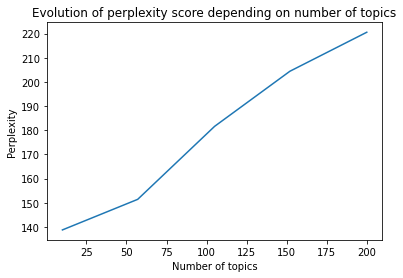

The process took: 0hour:4min:19sec


In [60]:
process_time_starts()
lda(c_vectorizer, X_bag_of_words_train, X_bag_of_words_test)
time_elapsed()

Extracting term frequency features for LDA...


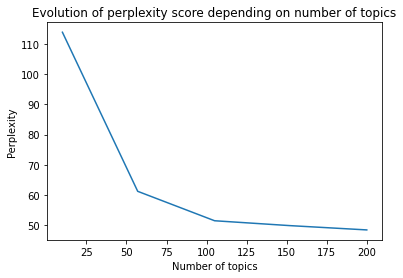

The process took: 0hour:4min:6sec


In [61]:
process_time_starts()
lda(tfidfVectorizer,X_tfidf_train, X_tfidf_test )
time_elapsed()

#### 2.1.2 Recommendation algorithm based on unsupervised topic modeling
Topics are automatically assigned based on word and component weight

In [0]:
n_topics = 55 # based on perplexity calculations

In [0]:
def Recommend_tags(text, model):
    
    ''' Recomendation system for stackoverflow posts based on a lda model, 
    it returns up to 5 tags.
    Parameters:
    text: the stackoverflow post of user
    data_train: data to fit the model with
    '''

    threshold = 0.011
    list_scores = []
    list_words = []
    used = set()
       
    text_tfidf = tfidfVectorizer.transform([text])
    text_projection = model.transform(text_tfidf)
    feature_names = tfidfVectorizer.get_feature_names()
    components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis] # normalization

    for topic in range(n_topics):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(components[topic].argsort()[:-5:-1], sorted(components[topic])[:-5:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y,tag) in sorted(zip(list_scores,list_words), key=lambda pair: pair[0], reverse=True)]
    unique_results = [x for x in results if x not in used] # get only unique tags
    tags = " ".join(results[:5])
    
    return tags

In [0]:
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(X_tfidf_train)

In [37]:
process_time_starts()
LDA_tags = [Recommend_tags(text, lda_model) for text in X_test ]
time_elapsed()

The process took: 0hour:1min:12sec


In [38]:
df_xtest = pd.DataFrame(X_test).reset_index()
df_ytest = pd.DataFrame(y_test).reset_index()

df_test = pd.merge(df_xtest, df_ytest)
df_test.drop('index', axis=1, inplace=True)
df_test['LDA_tags'] = LDA_tags
df_test.head()

,Lemma,taglist,LDA_tags
0,"['instal', 'libv', 'gem', 'o', '+', 'try', 'in...",gem rubygems osx-mavericks osx-yosemite libv8,find error build install user
1,"['right', 'leave', 'support', 'twitter', 'boot...",css html twitter-bootstrap twitter-bootstrap-3,create new script difference element
2,"['operator', 'mysql', 'work', 'code', 'write',...",mysql sql operators spaceship-operator,name mysql source set error
3,"['warn', 'implicit', 'declaration', 'function'...",c compiler-warnings,function error import library size
4,"['exportimport', 'job', 'jenkins', 'possible',...",jenkins,different test reference app number


#### 2.1.3 Performance evaluation of LDA predictions

##### Baseline: we create a tags vector with a dummy classifier 

In [0]:
# Dummy Classifier (baseline)

dummy_clf = DummyClassifier(random_state=0, strategy="most_frequent")

model_dummy = dummy_clf.fit(X_tfidf_train, y_train)
y_dummy_pred = model_dummy.predict(X_tfidf_test)

##### Cosine similarity as score metrics:

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.
We have to construct a vector space from all the ‘sentences’ in tags arrays. We do so by using the TF-IDF approach.

In [0]:
y_tfidf_test = tfidfVectorizer.transform(y_test)
y_tfidf_LDA = tfidfVectorizer.transform(LDA_tags)
y_tfidf_dummy = tfidfVectorizer.transform(y_dummy_pred)
#print(y_tfidf_test.shape, y_tfidf_LDA.shape, y_tfidf_dummy.shape)

##### Verify scores

In [41]:
# Cosine similarity varies between 0 and 1.
# If the predicted tags are exactly the same as those given by stackoverflow, cosine similarity is = 1
#  to have one number we need reshaping 1D vectors representing tags, as 2D vectors(-1,1)
print('Dummy score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_dummy.reshape(1,-1))) 
print('LDA score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_LDA.reshape(1,-1)))

Dummy score: [[0.05342378]]
LDA score: [[0.18009483]]


### 2.2 Tags reccommendation with non-negative matrix factorization(NMF) topic modelling

In [0]:
nmf_model = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X_tfidf_train)

In [44]:
process_time_starts()
NMF_tags = [Recommend_tags(text, nmf_model) for text in X_test ]
time_elapsed()

The process took: 0hour:1min:10sec


In [45]:
df_test['NMF_tags'] = NMF_tags
df_test.head()

,Lemma,taglist,LDA_tags,NMF_tags
0,"['instal', 'libv', 'gem', 'o', '+', 'try', 'in...",gem rubygems osx-mavericks osx-yosemite libv8,find error build install user,error package compile install option
1,"['right', 'leave', 'support', 'twitter', 'boot...",css html twitter-bootstrap twitter-bootstrap-3,create new script difference element,project compile build
2,"['operator', 'mysql', 'work', 'code', 'write',...",mysql sql operators spaceship-operator,name mysql source set error,error null server sql thread
3,"['warn', 'implicit', 'declaration', 'function'...",c compiler-warnings,function error import library size,function return
4,"['exportimport', 'job', 'jenkins', 'possible',...",jenkins,different test reference app number,


In [46]:
y_tfidf_NMF = tfidfVectorizer.transform(NMF_tags)
print('Dummy score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_dummy.reshape(1,-1))) 
print('NMF score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_NMF.reshape(1,-1)))

Dummy score: [[0.05342378]]
NMF score: [[0.18110464]]


## 3. Supervised topic modeling

To evaluate the supervised training models, I'll use the Jaccard score since it's the best fitted for multi label classification. 
https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics

In [0]:
def print_score(y_pred, clf):
    
    print("Clf: ", clf.__class__.__name__)
    print("Jaccard score: {}".format(jaccard_score(y_test_bin, y_pred, average='weighted'))) # measure of similarity for the two sets of data. Average is set to "samples" since is between two multilabeled
    print("Hamming loss: {}".format((hamming_loss(y_pred, y_test_bin)))) #% of the wrong labels to the total number of labels
    print("Accuracy score: {}".format((accuracy_score(y_test_bin, y_pred))))   
    print("---")    

### 3.1 Evaluate several classifiers

3.1.1 How many relevant features do we have?

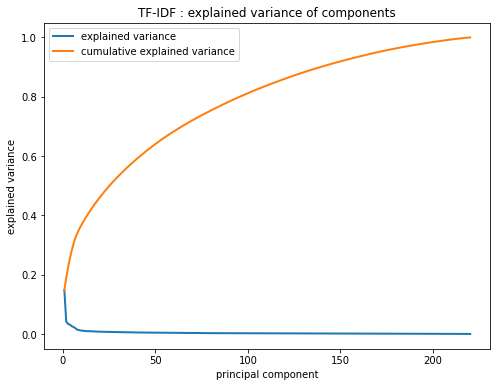

In [28]:
#scaler = StandardScaler()
#X_tfidf_train_std = scaler.fit_transform(X_tfidf_train)


X_train_pca = PCA().fit(X_tfidf_train)

fig, ax = plt.subplots(figsize=(8,6))

x_values = range(1, X_train_pca.n_components_+1)

ax.plot(x_values, X_train_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(X_train_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('TF-IDF : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.legend()
plt.show()

In [29]:
pca = PCA(n_components=100)


X_PCA_train = pca.fit_transform(X_tfidf_train)
X_PCA_test = pca.fit_transform(X_tfidf_test)

print(X_PCA_train.shape, X_PCA_test.shape)

(29740, 100) (7435, 100)


3.1.2 Test several classifiers for original matrix and that reduced by PCA

In [70]:
lr = LogisticRegression()
sgd = SGDClassifier() # stochastic gradient descent (SGD) learning
mn = MultinomialNB() # naive Bayes algorithm for multinomially distributed data,
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier() # Passive: if correct classification, keep the model; Aggressive: if incorrect classification, update to adjust to this misclassified example.


classifiers_list = [dummy_clf,lr, svc, mn, perceptron, pac]
classifiers_jaccard_scores = []
classifiers_hamming_losses = []
classifiers_accuracy_scores = []

for classifier in classifiers_list:
    process_time_starts()
    
    clf = MultiOutputClassifier(classifier) # check sklearn
    print("fit running....")
    clf.fit(X_tfidf_train, y_train_bin)
    y_pred = clf.predict(X_tfidf_test)
    classifiers_jaccard_scores.append(jaccard_score(y_test_bin, y_pred, average='weighted'))
    classifiers_hamming_losses.append((hamming_loss(y_pred, y_test_bin)))
    classifiers_accuracy_scores.append(accuracy_score(y_test_bin, y_pred))

    
    print("time up")
    time_elapsed()
    print_score(y_pred, classifier)
    
    print("---")

fit running....
time up
The process took: 0hour:0min:1sec
Clf:  DummyClassifier
Jaccard score: 0.0
Hamming loss: 0.014711499663752521
Accuracy score: 0.0902488231338265
---
---
fit running....
time up
The process took: 0hour:2min:20sec
Clf:  LogisticRegression
Jaccard score: 0.29271947102571577
Hamming loss: 0.012127774041694687
Accuracy score: 0.26388702084734367
---
---
fit running....
time up
The process took: 0hour:3min:30sec
Clf:  LinearSVC
Jaccard score: 0.2844203038386725
Hamming loss: 0.012240753194351042
Accuracy score: 0.26509751176866175
---
---
fit running....
time up
The process took: 0hour:0min:5sec
Clf:  MultinomialNB
Jaccard score: 0.18744875019383803
Hamming loss: 0.11266442501681237
Accuracy score: 0.0033624747814391394
---
---
fit running....
time up
The process took: 0hour:0min:19sec
Clf:  Perceptron
Jaccard score: 0.25169369565916877
Hamming loss: 0.01878950907868191
Accuracy score: 0.17202420981842637
---
---
fit running....
time up
The process took: 0hour:0min:24

**Test on PCA reduced features**



In [32]:
dummy_clf = DummyClassifier(random_state=0, strategy="most_frequent")
lr = LogisticRegression()
sgd = SGDClassifier() # stochastic gradient descent (SGD) learning
mn = MultinomialNB() # naive Bayes algorithm for multinomially distributed data,
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier() # Passive: if correct classification, keep the model; Aggressive: if incorrect classification, update to adjust to this misclassified example.
classifiers_list = [dummy_clf,lr, perceptron, pac]
for classifier in classifiers_list:
    process_time_starts()
    
    clf = MultiOutputClassifier(classifier)
    clf.fit(X_PCA_train, y_train_bin)
    y_pred = clf.predict(X_PCA_test)
    
    print("time up")
    time_elapsed()
    print('score after PCA')
    print_score(y_pred, classifier)
        
    print("---")

time up
The process took: 0hour:0min:0sec
score after PCA
Clf:  DummyClassifier
Jaccard score: 0.0
Hamming loss: 0.010833445415826048
Accuracy score: 0.06671149966375252
---
---
time up
The process took: 0hour:2min:6sec
score after PCA
Clf:  LogisticRegression
Jaccard score: 0.020225184227947564
Hamming loss: 0.0421286707016364
Accuracy score: 0.05043712172158709
---
---
time up
The process took: 0hour:0min:16sec
score after PCA
Clf:  Perceptron
Jaccard score: 0.02397695743609537
Hamming loss: 0.08931719345438242
Accuracy score: 0.008338937457969065
---
---
time up
The process took: 0hour:0min:20sec
score after PCA
Clf:  PassiveAggressiveClassifier
Jaccard score: 0.024526205930363375
Hamming loss: 0.04447971306881865
Accuracy score: 0.04572965702757229
---
---


3.1.3 Test KNN

- Find optimal number of neighbors for KNN Classifier
- Run optimized algorythm

In [0]:
process_time_starts()

Jaccard_KNN =[]
Hamming_KNN = []
for n in range(2,60,8):
    knn = KNeighborsClassifier(n_neighbors = n)
    knn_clf = knn.fit(X_tfidf_train, y_train_bin)
    y_pred = knn_clf.predict(X_tfidf_test)
    Jaccard_KNN.append(jaccard_score(y_test_bin, y_pred, average='samples'))
    Hamming_KNN.append(hamming_loss(y_pred, y_test_bin))

time_elapsed()

KNN_range = np.arange(2,60,8)
df_KNN = pd.DataFrame(KNN_range, columns = ['range'])
df_KNN['Jaccard_score'] = Jaccard_KNN
df_KNN['Hamming_loss'] = Hamming_KNN

neighbors_max = df_KNN.iloc[df_KNN['Jaccard_score'].argmax(), 0] # the number K of neighbors that returns highest score 
print("the number K of neighbors that returns highest score is: ",neighbors_max)

In [60]:
process_time_starts()
knn = KNeighborsClassifier(n_neighbors = 10) # KNN optimized
knn_clf = knn.fit(X_tfidf_train, y_train_bin)
y_pred_KNN = knn_clf.predict(X_tfidf_test)
time_elapsed()
classifiers_jaccard_scores.append(jaccard_score(y_test_bin, y_pred_KNN, average='weighted'))
classifiers_hamming_losses.append((hamming_loss(y_pred_KNN, y_test_bin)))
classifiers_accuracy_scores.append(accuracy_score(y_test_bin, y_pred_KNN))
classifiers_list.append('KNN')

The process took: 0hour:1min:54sec


3.1.4 Run Random Forest Classifier

In [62]:
process_time_starts()
rf = RandomForestClassifier(max_depth=35000, random_state=42, n_jobs = -1, n_estimators=80)#, parameters optimized to balance consumption and accuracy
rf_clf = rf.fit(X_tfidf_train, y_train_bin)
# apply the trained random forest model
y_pred_RF = rf_clf.predict(X_tfidf_test)
time_elapsed()


The process took: 0hour:1min:19sec


In [0]:
classifiers_jaccard_scores.append(jaccard_score(y_test_bin, y_pred_RF, average='weighted'))
classifiers_hamming_losses.append((hamming_loss(y_pred_RF, y_test_bin)))
classifiers_accuracy_scores.append(accuracy_score(y_test_bin, y_pred_RF))
classifiers_list.append('Random Forest')



3.1.3 compare all scores

In [68]:

classifiers_list =['Dummy Classifier', 'Logistic Regression', 'Multinomial Naive Bayes', 'LinearSVC','Perceptron', 'PassiveAggressiveClassifier', 'K-Neighbors Classifier', "Random Forest Classifier"]

df_clf = pd.DataFrame(classifiers_list, columns = ['classifiers'])
df_clf['Jaccard_score'] = classifiers_jaccard_scores
df_clf['Hamming_loss'] = classifiers_hamming_losses
df_clf['Accuracy'] = classifiers_accuracy_scores
df_clf = df_clf.sort_values(by=['Hamming_loss'])
best_classifier = df_clf.iloc[df_clf['Accuracy'].argmax(), 0]
print('The best classifier among those tested is: ',best_classifier)
df_clf

The best classifier among those tested is:  Random Forest Classifier


,classifiers,Jaccard_score,Hamming_loss,Accuracy
7,Random Forest Classifier,0.273065,0.011221,0.288500
1,Logistic Regression,0.292719,0.012128,0.263887
2,Multinomial Naive Bayes,0.283482,0.012351,0.260390
6,K-Neighbors Classifier,0.157818,0.012893,0.193141
0,Dummy Classifier,0.000000,0.014711,0.090249
4,Perceptron,0.251694,0.018790,0.172024
5,PassiveAggressiveClassifier,0.262922,0.020270,0.163282
3,LinearSVC,0.187449,0.112664,0.003362


[]

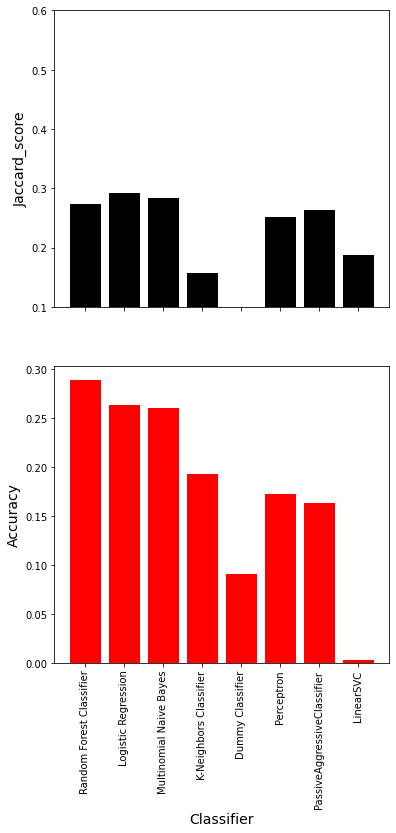

In [67]:
plt.figure(figsize=(6, 12))
plt.subplot(211)
plt.bar(df_clf['classifiers'],df_clf['Jaccard_score'], color = 'k')
plt.ylabel('Jaccard_score',fontsize = 14)
plt.ylim((0.1, 0.6))   # set the ylim to bottom, top
plt.xticks(df_clf['classifiers']," ")

plt.subplot(212)
plt.bar(df_clf['classifiers'],df_clf['Accuracy'], color = 'r') 
plt.ylabel('Accuracy',fontsize = 14)
#plt.ylim((0.1, 0.3))
plt.xlabel('Classifier', fontsize = 14)
plt.xticks(rotation=90)
plt.plot()

### 3.2 extract tags out of the matrix predicted by the best classifier

In [0]:
y_pred_rf_matrix = pd.DataFrame(y_pred_RF, columns=y_test_bin.columns)
y_pred_rf_matrix [:1]

In [0]:

def get_tags(df):
    indexarray = np.arange(0,len(df.index))
    taglist =[]
    def unique_list(l):
      x = []
      for a in l:
        if a not in x:
          x.append(a)
      return x
    
    for i in indexarray:
        onelist = df.columns[(df > 0).iloc[i]].tolist()
        uniques = unique_list(onelist)
        taglist.append(uniques)
    return taglist

In [0]:
tags_rf = get_tags(y_pred_rf_matrix)
RF_tags = [' '.join(map(str, l)) for l in tags_rf]
df_test['Random_Forest_tags'] = RF_tags


In [0]:
clf = OneVsRestClassifier(lr)
print("fit running....")
clf.fit(X_tfidf_train, y_train_bin)
y_pred = clf.predict(X_tfidf_test)

In [0]:
y_pred_lr_matrix = pd.DataFrame(y_pred, columns=y_test_bin.columns)
tags_lr = get_tags(y_pred_lr_matrix)
LR_tags = [' '.join(map(str, l)) for l in tags_lr]
df_test['LinearRegression_tags'] = LR_tags

df_test.head()

In [0]:
y_tfidf_RF = tfidfVectorizer.transform(RF_tags)
y_tfidf_LR = tfidfVectorizer.transform(LR_tags)
print('Dummy score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_dummy.reshape(1,-1))) 
print('RF score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_RF.reshape(1,-1)))
print('LR score:',cosine_similarity(y_tfidf_test.reshape(1,-1), y_tfidf_LR.reshape(1,-1)))

Much higher cosine similarity than with unsupervised methods

### 3.3 Reverse neural networks

In [0]:
from keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [0]:

df_Xtrain, df_Xtest = train_test_split(X)

def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0
            
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=220))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator=batch_generator(X_tfidf_train, y_train, 32),
                    epochs=5, validation_data=(X_tfidf_test, y_test),
                    steps_per_epoch= 32)

